RANDOM CROSS VALIDATION

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

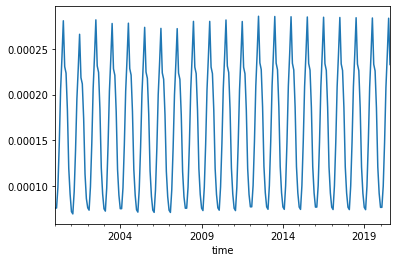

In [3]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')
nh3.plot()
plt.show()

In [4]:
import random

random.seed(0)

def random_training_validation_window(ts, size, validation_size):

    n = len(ts)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return ts[start:end], ts[end:end+validation_size]

In [5]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [6]:
from statsmodels.tsa.arima.model import ARIMA

def random_cross_validation(ts, order, seasonal_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    sses = []
    mses = []

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(nh3, train_months/len(nh3), validation_months)

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aicc)
        bics.append(model.bic)

        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        sses.append(model.sse)
        mses.append(model.mse)
    
    return np.mean(rmses), np.mean(aics), np.mean(bics), np.mean(sses),  np.mean(mses), np.mean(np.abs(acf(model.resid)))

In [7]:
import numpy as np
from statsmodels.tsa.stattools import acf

def model_selection(ts, cv_iterations=1, verbose=False):
    
    p_list = [1, 2, 3]
    q_list = [0, 1, 2]
    P_list = [1]
    Q_list = [0]
    s_list = [12]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for s in s_list:
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        rmse, aic, bic, sse, mse, meaacf = random_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s),                                                                                    times=cv_iterations)

                        results[model_name] = {
                            'order' : (p,0,q),
                            'seasonal_order' : (P,0,Q,s),
                            'aic' : aic,
                            'bic' : bic,
                            'sse' : sse,
                            'rmse' : rmse,
                            'mse' : mse,
                            'index' : model_idx,
                            'mean_abs_acf': meaacf       
                            }

                        idx += 1
                    
                    
    return results

In [8]:
results = model_selection(nh3, cv_iterations=40, verbose=True)

0: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12)
1: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12)
2: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12)
3: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=0, s=12)
4: SARIMA(p=2, d=0, q=1, P=1, D=0, Q=0, s=12)
5: SARIMA(p=2, d=0, q=2, P=1, D=0, Q=0, s=12)
6: SARIMA(p=3, d=0, q=0, P=1, D=0, Q=0, s=12)
7: SARIMA(p=3, d=0, q=1, P=1, D=0, Q=0, s=12)
8: SARIMA(p=3, d=0, q=2, P=1, D=0, Q=0, s=12)


In [9]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
sses = [v['sse'] for k, v in results.items()]
mses = [v['mse'] for k, v in results.items()]
maacf = [v['mean_abs_acf'] for k, v in results.items()]

In [10]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

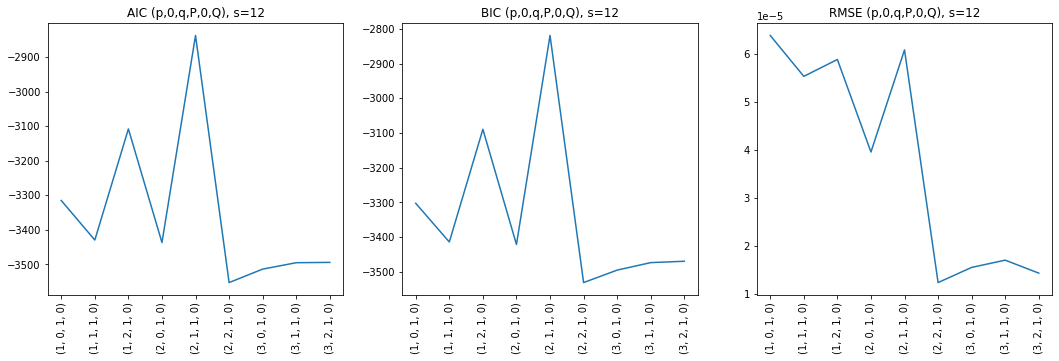

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
indices = np.arange(0, len(results), 1)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [12]:
print('min AIC: {}, min BIC {}, min RMSE {}'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses)))

min AIC: 5, min BIC 5, min RMSE 5


In [13]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'order': (2, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3552.4671148543466,
 'bic': -3530.767579688813,
 'sse': 3.676573082862148e-08,
 'rmse': 1.2301360364685515e-05,
 'mse': 2.0425406015900824e-10,
 'index': 5,
 'mean_abs_acf': 0.15204431661525247}

In [14]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'order': (2, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3552.4671148543466,
 'bic': -3530.767579688813,
 'sse': 3.676573082862148e-08,
 'rmse': 1.2301360364685515e-05,
 'mse': 2.0425406015900824e-10,
 'index': 5,
 'mean_abs_acf': 0.15204431661525247}

In [15]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'order': (2, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3552.4671148543466,
 'bic': -3530.767579688813,
 'sse': 3.676573082862148e-08,
 'rmse': 1.2301360364685515e-05,
 'mse': 2.0425406015900824e-10,
 'index': 5,
 'mean_abs_acf': 0.15204431661525247}

In [16]:
min_sse_model = [v for k,v in results.items() if v['sse'] == np.min(sses)][0]
min_sse_model

{'order': (2, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3552.4671148543466,
 'bic': -3530.767579688813,
 'sse': 3.676573082862148e-08,
 'rmse': 1.2301360364685515e-05,
 'mse': 2.0425406015900824e-10,
 'index': 5,
 'mean_abs_acf': 0.15204431661525247}

In [17]:
min_mse_model = [v for k,v in results.items() if v['mse'] == np.min(mses)][0]
min_mse_model

{'order': (2, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3552.4671148543466,
 'bic': -3530.767579688813,
 'sse': 3.676573082862148e-08,
 'rmse': 1.2301360364685515e-05,
 'mse': 2.0425406015900824e-10,
 'index': 5,
 'mean_abs_acf': 0.15204431661525247}

In [19]:
min_abs_acf_model = [v for k,v in results.items() if v['mean_abs_acf'] == np.min(maacf)][0]
min_abs_acf_model

{'order': (2, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3552.4671148543466,
 'bic': -3530.767579688813,
 'sse': 3.676573082862148e-08,
 'rmse': 1.2301360364685515e-05,
 'mse': 2.0425406015900824e-10,
 'index': 5,
 'mean_abs_acf': 0.15204431661525247}

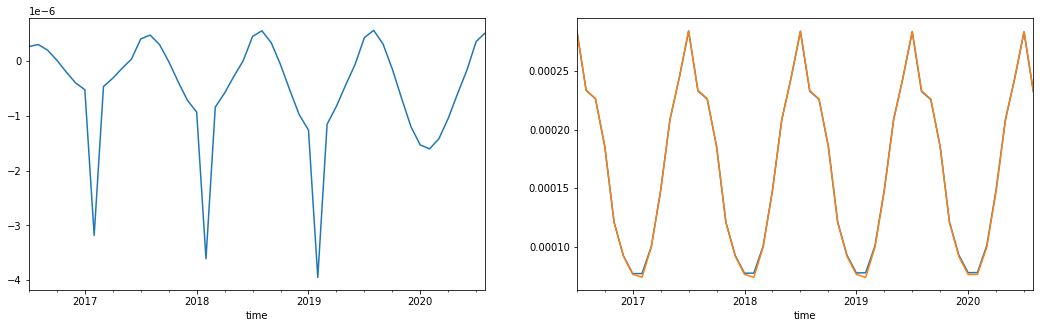

In [20]:
import pandas as pd

train_data, validation_data = utils.ts_train_test_split(nh3, .8)
validation_data = validation_data

best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()
predictions, errors = multiple_forecasts(model=best_model, ts=validation_data, times=len(validation_data), refit=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors, index=validation_data.index).plot(ax=axs[0])

pd.Series(predictions, index=validation_data.index).plot(ax=axs[1])
validation_data.plot(ax=axs[1])
plt.show()

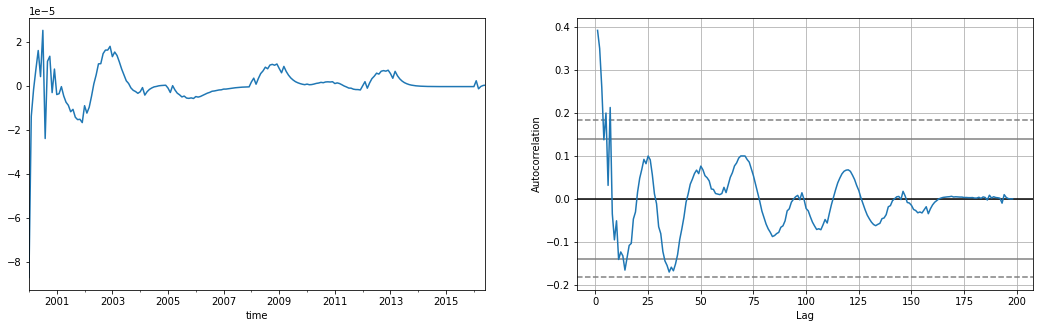

In [21]:
from pandas.plotting import autocorrelation_plot

errors = best_model.resid

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors[:]).plot(ax=axs[0])
autocorrelation_plot(errors[:], ax=axs[1])
plt.show()

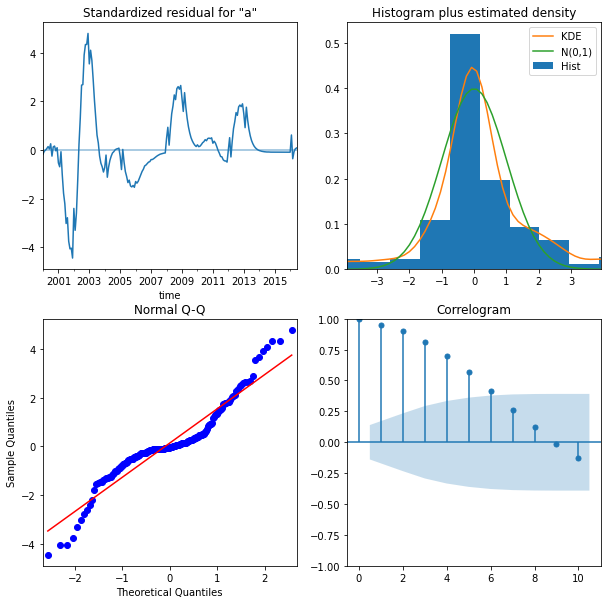

In [22]:
best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

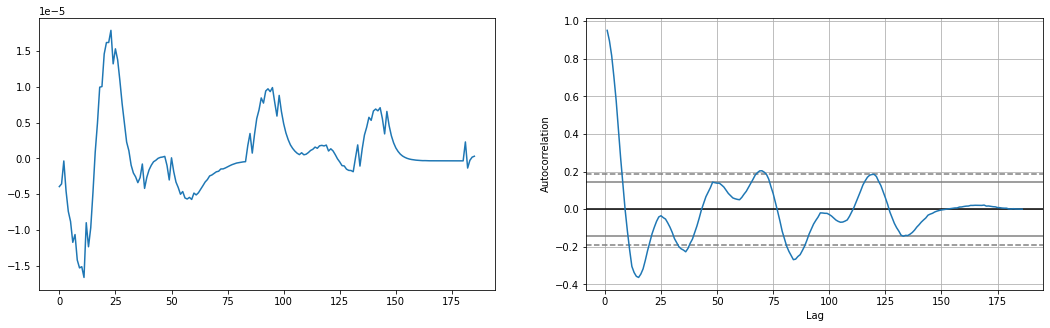

In [23]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors).plot(ax=axs[0])
autocorrelation_plot(errors, ax=axs[1])
plt.show()

In [24]:
best_model.test_heteroskedasticity(method='breakvar')

array([[1.13136305e-01, 4.46957855e-16]])

In [25]:
best_model.test_normality('jarquebera')

array([[4.64058986e+01, 8.37697364e-11, 2.57046580e-01, 5.31531113e+00]])

In [26]:
print(best_model.pvalues)

const       0.028312
ar.L1       0.000000
ar.L2       0.000000
ma.L1       0.000000
ma.L2       0.000000
ar.S.L12    0.000000
sigma2      0.928486
dtype: float64


In [27]:
best_model.params

const       1.624715e-04
ar.L1       1.688108e+00
ar.L2      -9.476931e-01
ma.L1      -1.305658e+00
ma.L2       4.209859e-01
ar.S.L12    9.993289e-01
sigma2      1.399989e-11
dtype: float64

In [28]:
best_model.test_serial_correlation('boxpierce', lags=12)[0][1]

array([7.06773862e-041, 3.19561669e-074, 1.69414471e-101, 2.99145741e-121,
       3.58004600e-134, 1.40809629e-140, 1.77068339e-142, 4.08278758e-142,
       3.83725523e-141, 7.65763751e-141, 5.39183289e-142, 4.65465232e-145])

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(errors, model_df=len(best_model.param_names)-1)[1]

array([            nan,             nan,             nan,             nan,
                   nan,             nan, 1.62486097e-145, 9.28889844e-145,
       1.90984112e-143, 8.21734248e-143, 1.08921389e-143, 1.26588286e-146,
       1.59483655e-150, 4.31335220e-155, 6.69288259e-160, 3.38775994e-164,
       1.01886261e-167, 4.41166972e-170, 2.42469505e-171, 7.71772894e-172,
       1.01234795e-171, 2.92204361e-171, 1.38670314e-170, 8.31836768e-170,
       5.10044693e-169, 2.79169627e-168, 1.37088133e-167, 4.96109214e-167,
       1.14376019e-166, 1.32357371e-166, 5.33982055e-167, 9.23023145e-168,
       6.26751313e-169, 2.46511849e-170, 6.87580768e-172, 1.15889332e-173,
       4.48254031e-175, 5.72192156e-176, 1.67221465e-176, 1.47509182e-176])